In [12]:
%load_ext autoreload
%autoreload 2

In [2]:
DEVICE = 'cuda'

In [8]:
from air.datasets.abstract_exp import dataset_abstract


num_h = 4
dim_x = 10
dim_y = 10
dim_z = 6
dim_a = 2

epochs = 300
lr, beta = (1e-4, 0.001)

seed_funcs= 1110

data, loader_test, loader = dataset_abstract(N = 3000,
                                            num_h = num_h,
                                            dim_x= dim_x,
                                            dim_y = dim_y,
                                            size_train = 0.8,
                                            BS = 100, seed_funcs= seed_funcs, device = DEVICE)

In [9]:
from air.models import VAIR

import torch
torch.manual_seed(0)

vair = VAIR(dim_x = dim_x, # Dimension input to encoder
             dim_z = dim_z, # Dimension latent
             dim_a = dim_a, # Dimension action representation               
             dim_y = dim_y,
).to(DEVICE)

In [5]:
from fastai.vision.all import Learner, Adam
from air.losses_metrics import beta_mse_loss, save_logvars, save_separate_losses

In [10]:
learn_vair = Learner(data, 
                     vair,
                     loss_func = beta_mse_loss(loss_objective = 'H',
                                               beta = beta,
                                               recon_objective='mse'), 
                     opt_func= Adam,
                     cbs = (
                         save_logvars(),
                         save_separate_losses(loader)
                     )     
             )


with learn_vair.no_logging(): learn_vair.fit(epochs, lr = lr)

In [30]:
import matplotlib.pyplot as plt

In [31]:
colors = ['#03275aff', '#1a7dd7ff', '#f2b809ff',  '#52b788', '#f34605ff']

passive = [1, 5]

''

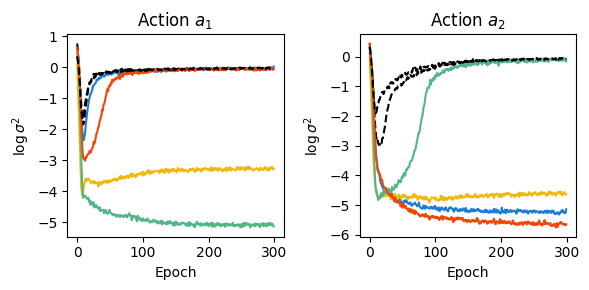

In [50]:
fig, ax = plt.subplots(1,2, figsize = (6,3), tight_layout = True)

for idx in range(2):
    idx_c = 0
    for z in range(learn_vair.dim_z):
        if z in passive:
            ls = '--'; c = 'k'
        else:
            ls = '-'; c = colors[idx_c+1]
            idx_c += 1

        ax[idx].plot(learn_vair.save_logvars.logvars[:, idx, z].detach().cpu(), c = c, label = f'$\sigma_{z+1}$', ls = ls);
    ax[idx].set_title(f'Action $a_{idx+1}$')


plt.setp(ax, xlabel = 'Epoch', ylabel = r'$\log \sigma^2$')
;

In [20]:
from air.datasets.abstract_exp import random_functions

[Text(0, 0.5, '$c$')]

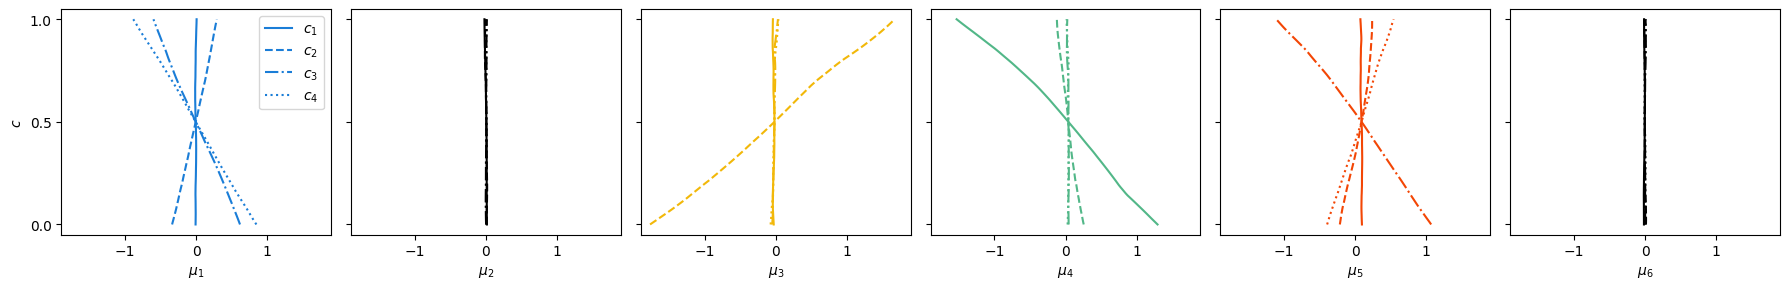

In [46]:
fig, axes = plt.subplots(1, learn_vair.dim_z, figsize=(learn_vair.dim_z*3, 3), tight_layout=False) 

line_styles = ['-', '--', '-.', ':']

for idxh in range(4):

    h = torch.ones(N,4)*0.5
    h[:, idxh] = torch.linspace(0, 1, N)
    inp = random_functions(h.clone(), dim_x, seed_funcs)   

    mus = learn_vair.encoder(inp.to(DEVICE)).detach().cpu()    

    idx_c = 0
    for idxm, (m, ax) in enumerate(zip(mus.T, axes)):
        if idxm in passive:
            c = 'k'
        else:
            c = colors[idx_c+1]
            idx_c += 1 
        ax.plot(m, h[:, idxh], label = fr'$c_{idxh+1}$', c = c, ls = line_styles[idxh]);

        if idxh == 0:
            ax.set_xlabel(f'$\mu_{idxm+1}$')

axes[0].legend()
plt.setp(axes, xlim = (-1.9, 1.9), yticks = [0,0.5,1]);
plt.setp(axes[1:], yticklabels = [])
plt.setp(axes[0], ylabel = r'$c$')